**Content**

First let's import everything we need to run the rest of the notebook.

In [144]:
import numpy as np
import scipy.stats as ss
import dedalus.public as d3
import logging
import h5py
logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt

**Problem Equations**

The Boussinesq equations are given by
\begin{align}
\begin{split}
     \frac{D \boldsymbol{U} }{Dt}&= -\nabla P + Re^{-1} \Delta \boldsymbol{U} + B \boldsymbol{z}, \quad \nabla \cdot \boldsymbol{U} = 0, \\
    \frac{D B }{Dt}         &= Pe^{-1}\nabla^2 B + Pe^{-1}Q, \quad \text{on} \quad  \Omega: [0,L_X/H] \times [0,1],
\end{split}
\end{align}
subject to the no-slip velocity and buoyancy boundary conditions prescribed by the stochastic differential equation
\begin{equation}
 dB_t = a( \mu_z - B_t) dt + \sigma dW_t , \quad \text{at} \quad z = 0,1, \\
\end{equation}
where $a,\sigma$ are drift and diffusion coefficients respectively, $\mu_z$ the mean buoyancy on the boundary and $W_t$ the Wiener process which evolves independently on each boundary. The steady state solution to the Fokker-Planck equation corresponding to this SDE is given by the normal distribution $\mathcal{N}(\mu_z,\frac{\sigma^2}{2a})$. As such this process is completely characterised by its mean $\mu_z$, variance $\sigma^2/2a$ and auto-correlation $\rho(s) = e^{-|s|/T_L}$ such that $T_L = \int_0^{\infty} \rho(s) ds$ is equivalent to the integral time-scale of this process.

Below we write a solver for the SDE:

In [145]:
def OU(Y_t,W_t,dt, μ_z,a,σ):
    """
    Ornstein-Ulhenbeck process
    """

    dW_t = np.sqrt(dt) * W_t

    # Euler Maruyama
    return  Y_t + a*(μ_z - Y_t)*dt + σ * dW_t

As well as for the Boussinesq equations where for simplicity we assume periodicity in the horizontal:

In [146]:
# Solver
def Solve(N=400,T=50,Nx=256,Nz=64,a=5,σ=1,W=None):

    Ra=2e06
    Pr=1

    # Bases
    coords = d3.CartesianCoordinates('x', 'z')
    dist   = d3.Distributor(coords, dtype=np.float64)
    xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, 4), dealias=3/2)
    zbasis = d3.ChebyshevT( coords['z'], size=Nz, bounds=(0, 1), dealias=3/2)

    # Fields
    p = dist.Field(name='p', bases=(xbasis,zbasis))
    b = dist.Field(name='b', bases=(xbasis,zbasis))
    u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
    tau_p  = dist.Field(name='tau_p')
    tau_b1 = dist.Field(name='tau_b1', bases=xbasis)
    tau_b2 = dist.Field(name='tau_b2', bases=xbasis)
    tau_u1 = dist.VectorField(coords, name='tau_u1', bases=xbasis)
    tau_u2 = dist.VectorField(coords, name='tau_u2', bases=xbasis)

    # Substitutions
    kappa= (Ra * Pr)**(-1/2) # 1/Pe
    nu   = (Ra / Pr)**(-1/2) # 1/Re
    x, z = dist.local_grids(xbasis, zbasis)
    ex,ez= coords.unit_vector_fields(dist)
    lift_basis = zbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)
    grad_u = d3.grad(u) + ez*lift(tau_u1) # First-order reduction
    grad_b = d3.grad(b) + ez*lift(tau_b1) # First-order reduction

    # Boundary conditions
    g_1 = dist.Field(name='g_1')
    g_0 = dist.Field(name='g_0')

    # Problem
    problem = d3.IVP([p, b, u, tau_p, tau_b1, tau_b2, tau_u1, tau_u2], namespace=locals())
    problem.add_equation("trace(grad_u) + tau_p = 0")
    problem.add_equation("dt(u) - nu*div(grad_u) + grad(p) - b*ez + lift(tau_u2) = - u@grad(u)")
    problem.add_equation("u(z=0) = 0")
    problem.add_equation("u(z=1) = 0") # no-slip
    problem.add_equation("integ(p) = 0") # Pressure gauge
    problem.add_equation("dt(b) - kappa*div(grad_b) + lift(tau_b2) = -u@grad(b)")
    problem.add_equation("b(z=1) = g_1")
    problem.add_equation("b(z=0) = g_0") 

    # Solver
    solver = problem.build_solver(d3.RK222)
    solver.stop_sim_time = T

    # Initial condition
    b.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise
    b['g'] *= z * (1 - z) # Damp noise at walls
    b['g'] += 1 - z # Add linear background

    np.random.seed(42)
    T_vec,dt = np.linspace(0,T,N,retstep=True)
    if W is None:
        W = ss.norm.rvs(loc=0, scale=1, size=(10*N,2))  # Make W very large as we have a variable time-step

    snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=0.1)
    snapshots.add_task(b,    name='b',scales=3/2)
    snapshots.add_task(grad_b       , name='grad_b',scales=3/2)
    # snapshots.add_task(-d3.div(d3.skew(u)), name='vorticity',scales=1)
    # snapshots.add_task(u@ex, name='u',scales=3/2)
    # snapshots.add_task(u@ez, name='w',scales=3/2)
    # snapshots.add_task(d3.grad(u@ez), name='grad_w',scales=3/2)
    # snapshots.add_task(d3.grad(p)   , name='grad_p',scales=3/2)

    # CFL
    CFL = d3.CFL(solver, initial_dt=T/N, cadence=10, safety=0.5, threshold=0.05, max_change=1.5, min_change=0.5, max_dt=T/N)
    CFL.add_velocity(u)

    # Main loop
    logger.info('Starting main loop')
    while solver.proceed:

        # Compute the 
        dt = CFL.compute_timestep()  # dt = t_n+1 - t_n
        n  = solver.iteration

        # Calculate the Bcs for Y_t+1
        # Specify the bcs according to OU process
        Bt_z0    = b(z=0).evaluate()['g'][0]
        g_0['g'] = OU(Y_t = Bt_z0, W_t=W[n,0],dt=dt,μ_z=1,a=a,σ=σ)

        Bt_z1    = b(z=1).evaluate()['g'][0]
        g_1['g'] = OU(Y_t = Bt_z1, W_t=W[n,1],dt=dt,μ_z=0,a=a,σ=σ)

        # Solve for Y_t+1
        solver.step(dt)

        if (solver.iteration-1) % 1000 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e'%(n, solver.sim_time, dt))

    return None

Setting $a=5,\sigma=1$ we use the solvers to generate a space time plot of the horizontally averaged buoyancy field starting from $B(\bm{x},t=0) = 1-z$.

2024-10-31 15:03:10,879 subsystems 0/1 INFO :: Building subproblem matrices 1/96 (~1%) Elapsed: 0s, Remaining: 16s, Rate: 5.9e+00/s
2024-10-31 15:03:12,096 subsystems 0/1 INFO :: Building subproblem matrices 10/96 (~10%) Elapsed: 1s, Remaining: 12s, Rate: 7.2e+00/s
2024-10-31 15:03:12,971 subsystems 0/1 INFO :: Building subproblem matrices 20/96 (~21%) Elapsed: 2s, Remaining: 9s, Rate: 8.8e+00/s
2024-10-31 15:03:13,856 subsystems 0/1 INFO :: Building subproblem matrices 30/96 (~31%) Elapsed: 3s, Remaining: 7s, Rate: 9.5e+00/s
2024-10-31 15:03:14,681 subsystems 0/1 INFO :: Building subproblem matrices 40/96 (~42%) Elapsed: 4s, Remaining: 6s, Rate: 1.0e+01/s
2024-10-31 15:03:15,497 subsystems 0/1 INFO :: Building subproblem matrices 50/96 (~52%) Elapsed: 5s, Remaining: 4s, Rate: 1.0e+01/s
2024-10-31 15:03:16,457 subsystems 0/1 INFO :: Building subproblem matrices 60/96 (~62%) Elapsed: 6s, Remaining: 3s, Rate: 1.0e+01/s
2024-10-31 15:03:17,447 subsystems 0/1 INFO :: Building subproblem ma

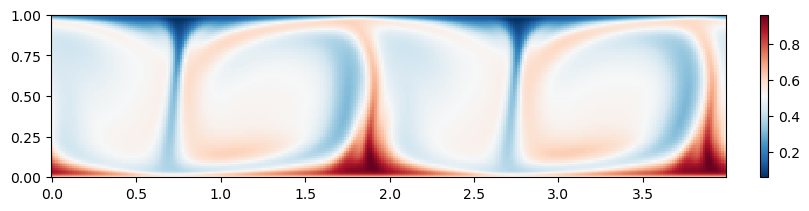

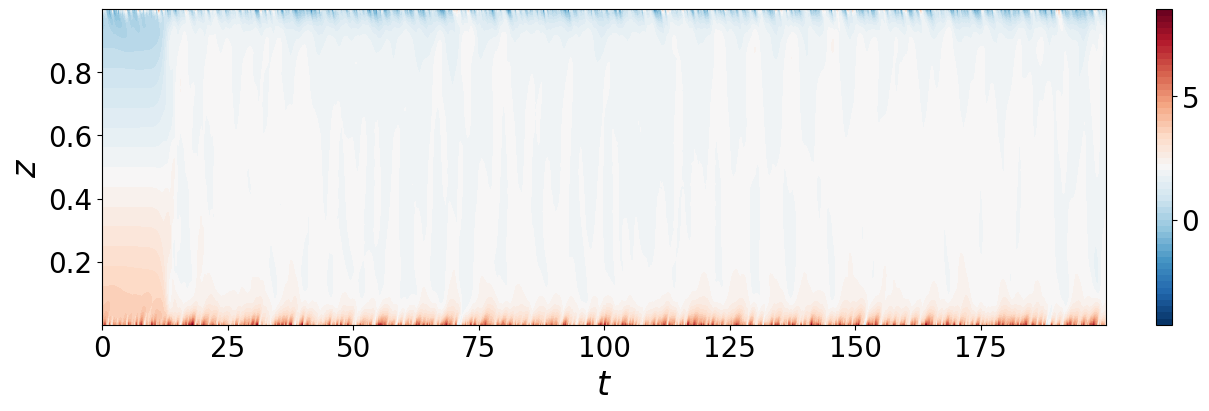

In [147]:
Solve(N=4*400,T=4*50,Nx=192,Nz=48,a=5,σ=1)

# Data loading
file   = h5py.File('snapshots/snapshots_s1.h5', mode='r')

# Data (t,x,z)
x_vec = file['tasks/b'].dims[1][0][:]
z_vec = file['tasks/b'].dims[2][0][:]
t_vec = file['tasks/b'].dims[0][0][:]
B_vec = file['tasks/b' ][:,:,:]

Y_vec = np.trapz(y=B_vec, x=x_vec, axis=1)

fig = plt.figure(figsize=(8,2),layout='constrained')
X,Z = np.meshgrid(x_vec, z_vec)
im = plt.pcolormesh(X, Z, B_vec[-1,:,:].T,cmap='RdBu_r',norm='linear')
plt.colorbar(im)
plt.show()

from matplotlib import ticker

fig = plt.figure(figsize=(12,4),layout='constrained')
plt.contourf(t_vec,z_vec,Y_vec.T,levels=50,cmap='RdBu_r',norm='linear')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20) 
tick_locator = ticker.MaxNLocator(nbins=3)
cbar.locator = tick_locator
cbar.update_ticks()

plt.xlabel(r'$t$',fontsize=24)
plt.ylabel(r'$z$',fontsize=24)
plt.tick_params(axis='both', labelsize=20)
plt.show()

The forward Kolmogorov equation describing the *global PDF* is given by
\begin{equation}
\frac{\partial }{ \partial t} f_{\bm{Y}} = -\frac{\partial}{ \partial y_i} \left( \bm{D}^{(1)}_i f_{\bm{Y}} \right) + \frac{\partial^2 }{ \partial y^2_i} \left( \bm{D}^{(2)}_i f_Y \right),
\end{equation}

where 

\begin{equation}
  \bm{D}^{(1)}=
  \phi\,\mathbb{E}_{\bm{Y}_{t}|\partial\Omega}
 \begin{bmatrix}
 0 \\
 \alpha_{1}\,\bm{n}\cdot\nabla B_{t} \\
 \end{bmatrix}
  \frac{f_{\bm{Y}|\partial\Omega}}{f_{\bm{Y}}} .
\end{equation}

arises due to diffusive fluxes at the boundary, which must be specified. The diffusion term for our system us given by either
\begin{equation}
  \bm{D}^{(2)}=-\alpha_{1}
  \mathbb{E}_{\bm{Y}_{t}}
    \begin{bmatrix}
    -1 & 0 \\
    0 & |\nabla B_{t}|^{2}\\
  \end{bmatrix},
\end{equation}
or
\begin{equation}
  \bm{D}^{(2)}=-\alpha_{1}
  \mathbb{E}_{\bm{Y}_{t}}
    \begin{bmatrix}
    0 & \partial_Z B_t/2 \\
    \partial_Z B_t/2  & |\nabla B_{t}|^{2}\\
  \end{bmatrix}.
\end{equation}


Here $f_{\bm{Y}|\partial\Omega}$ corresponds to the density of $\bm{Y}_t$ when it is sampled from the boundary $\partial \Omega$ while $f_{\bm{Y}}(\bm{y};t)$ is the global probability density . This density describes the probability of finding a buoyancy $b$ and height $z$ at a time $t$ in the interval $b \in [b_{min}, b_{max}], z \in [0,1]$. Given however that we are forcing the system by a stationary stochastic process we expect both $f_{\bm{Y}}$ and $f_{\bm{Y}|\partial\Omega}$ to be independent of time.

To evaluate these terms we rely on the fact that the system is stationary, such that if we integrate the equations for large time interval we can obtain well converged statistics.

*Note: This takes ???*

In [148]:
from scipy.interpolate import interp1d
Nz = 128

file = h5py.File('snapshots/snapshots_s1.h5', mode='r')
times = file['tasks/b'].dims[0][0][:]
pad = np.argwhere(times > 15)[0,0]

def interp(y, x, x_new):
  """Interpolate the Chebyshev points onto a uniform grid."""

  y_new = interp1d(x, y, axis=1, fill_value="extrapolate")

  return y_new(x_new)

def Data():

  # Data loading
  file   = h5py.File('snapshots/snapshots_s1.h5', mode='r')

  # Interpolate the data (t,x,z) from a Chebyshev grid onto a uniform grid
  x_data = file['tasks/b'].dims[1][0][:]
  z_cheb = file['tasks/b'].dims[2][0][:]
  times = file['tasks/b'].dims[0][0][:]
  Y_cheb = file['tasks/b' ][:,:,:]
  Yx_cheb = file['tasks/grad_b'][:,0,:,:]# d/dx
  Yz_cheb = file['tasks/grad_b'][:,1,:,:]# d/dz

  z_data  = np.linspace(0,1,Nz)
  s       = (len(times[pad:]),len(x_data),len(z_data))
  Y_data  = np.zeros(s)
  Yz_data = np.zeros(s)
  Y2_data = np.zeros(s)
  for i,t in enumerate(times[pad:]):
    Y_data[i,:,:] = interp(Y_cheb[pad + i,:,:], z_cheb, z_data)
    Yz_data[i,:,:] = interp(Yx_cheb[pad + i,:,:], z_cheb, z_data)
    Y2_data[i,:,:] = interp(Yx_cheb[pad + i,:,:]**2 + Yz_cheb[pad + i,:,:]**2 ,z_cheb, z_data)

  return times, z_data,Y_data,Yz_data,Y2_data

Having interpolated the data we first compute the joint PDF $f_{BZ}$, the diffusion term $\mathbb{E}_{\bm{Y}_t}[|\nabla B|^2]$ 

In [149]:
def pdf(B_data, Z_data, Nb=128):
    
    # (t,x,z) B_data shape

    # Create f_B to get the range
    fB, b_edges = np.histogram(B_data.flatten(), bins=Nb, density=True)
    b = 0.5*(b_edges[1:] + b_edges[:-1])

    # Create f_BZ
    fBZ = np.zeros((Nb,Nz))
    for j,_ in enumerate(Z_data):
        fBZ[:,j],_ = np.histogram(B_data[:,:,j], bins=Nb, range=(min(b), max(b)), density=True)
    
    return fB, fBZ, b, Z_data, b_edges


def diffusion(B_data, B2_data, Z_data, Nb=128, testing=True):
    
    # (t,x,z) B_data shape

    # Create 1D first to get the range
    E_B = np.zeros(Nb)
    f_XΦ,b_edges,φ = np.histogram2d(B_data.flatten(),B2_data.flatten(),bins=Nb,density=True)
    b = (b_edges[1:] + b_edges[:-1])/2
    φ = (φ[1:]+φ[:-1])/2
    dφ = φ[1] - φ[0]

    # E{Φ|X} = int_φ f_Φ|X(φ|x)*φ dφ
    if testing:
        E_B = np.nansum(φ*f_XΦ*dφ, axis=1)
    else:
        f_X = np.nansum(  f_XΦ*dφ, axis=1)    # f_X(x)
        E_B = np.nansum(φ*f_XΦ*dφ, axis=1)/f_X

    # Create 2D 
    data_range = [[min(b), max(b)], [min(φ), max(φ)]]
    E_BZ = np.zeros((Nb, Nz))
    for j in range(Nz):
        
        # HIST
        f_XΦ,_,φ = np.histogram2d(x=B_data[:,:,j].flatten(),y=B2_data[:,:,j].flatten(),bins=Nb,density=True, range=data_range)
        φ = (φ[1:]+φ[:-1])/2
        dφ = φ[1] - φ[0]

        if testing:
            E_BZ[:,j] = np.nansum(φ*f_XΦ*dφ,axis=1)
        else:
            f_X      = np.nansum(  f_XΦ*dφ,axis=1)
            E_BZ[:,j] = np.nansum(φ*f_XΦ*dφ,axis=1)/f_X

    
    return E_B, E_BZ, b, Z_data, b_edges

We then plot these terms out starting with the PDF

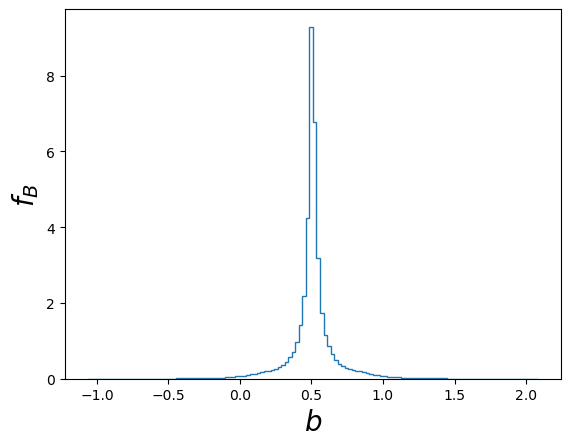

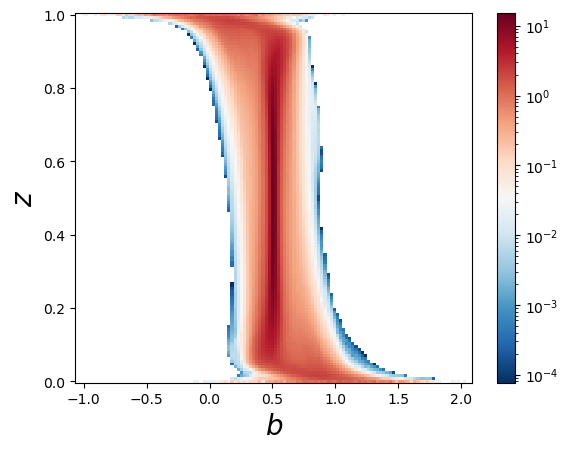

In [150]:
times, Z_data, B_data, Bz_data, B2_data = Data()

fB, fBZ, b, z, b_edges = pdf(B_data, Z_data, Nb=128)

fig = plt.figure()
plt.stairs(fB, b_edges)
plt.xlabel(r'$b$',fontsize=20)
plt.ylabel(r'$f_B$',fontsize=20)
plt.show()

fig = plt.figure()
B, Z = np.meshgrid(b, z)
im = plt.pcolormesh(B, Z, fBZ.T, cmap='RdBu_r' ,norm='log')
plt.colorbar(im)
plt.xlabel(r'$b$',fontsize=20)
plt.ylabel(r'$z$',fontsize=20)
plt.show()

and then the diffusion term

/tmp/ipykernel_50815/3737703568.py:33: RuntimeWarning: invalid value encountered in divide
  E_B = np.nansum(φ*f_XΦ*dφ, axis=1)/f_X
/tmp/ipykernel_50815/3737703568.py:49: RuntimeWarning: invalid value encountered in divide
  E_BZ[:,j] = np.nansum(φ*f_XΦ*dφ,axis=1)/f_X


2024-10-31 15:58:41,026 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode
2024-10-31 15:58:41,137 matplotlib.mathtext 0/1 INFO :: Substituting symbol E from STIXNonUnicode


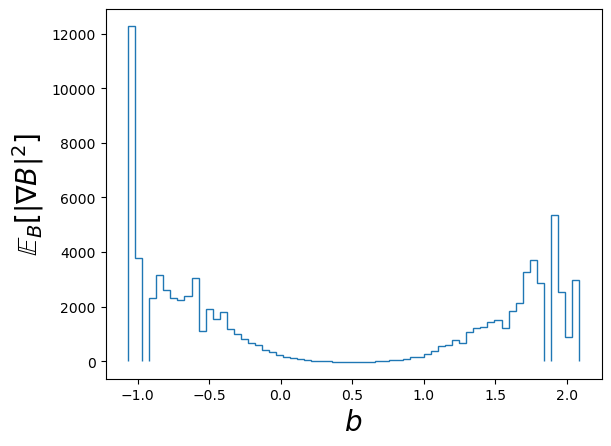

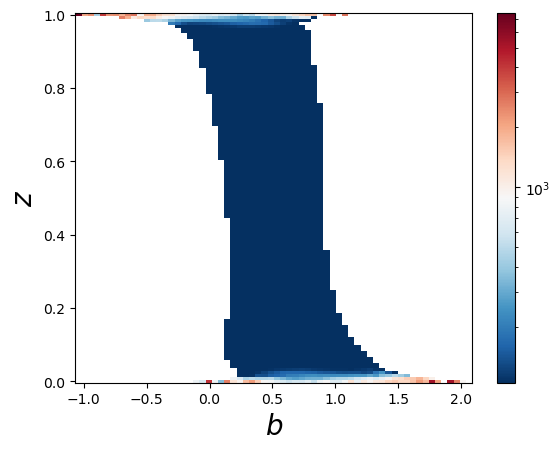

In [160]:
times, Z_data, B_data, Bz_data, B2_data = Data()


E_B, E_BZ, b, z, b_edges = diffusion(B_data, B2_data, Z_data, Nb=64, testing=True)

fig = plt.figure()
plt.stairs(E_B,b_edges)
plt.xlabel(r'$b$',fontsize=20)
plt.ylabel(r'$\mathbb{E}_B[|\nabla B|^2]$',fontsize=20)
plt.show()

fig = plt.figure()
B, Z = np.meshgrid(b, z)
im = plt.pcolormesh(B, Z, E_BZ.T, cmap='RdBu_r' ,norm='log')
plt.colorbar(im)
plt.xlabel(r'$b$',fontsize=20)
plt.ylabel(r'$z$',fontsize=20)
plt.show()

We then turn to computing the *drift coefficient* 
\begin{equation}
  \bm{D}^{(1)}_2 = \phi\,\mathbb{E}_{\bm{Y}_{t}|\partial\Omega} [ \alpha_{1}\,\bm{n}\cdot\nabla B_{t} ] \frac{f_{\bm{Y}|\partial\Omega}}{f_{\bm{Y}}},
\end{equation}
by using the fact that the product of the density $f_{Y|\partial \Omega }$ and the conditional average of the gradient of $Y_t$ restricted to the boundary $\mathbb{E}_{Y_t|\partial \Omega}[ \boldsymbol{n} \cdot \nabla Y_t ]$ can be expressed as
\begin{equation}
\mathbb{D}^{(1)} = \phi \mathbb{E}_{Y_t|\partial \Omega}[ \boldsymbol{n} \cdot \nabla Y_t ] f_{Y|\partial \Omega } = \phi \int \varphi f_{\boldsymbol{n} \cdot \nabla Y_t,Y|\partial \Omega}(\varphi, y) d\varphi. 
\end{equation}
We calculate this term by estimating the joint density $f_{\boldsymbol{n} \cdot \nabla Y_t,Y|\partial \Omega}(\varphi, y)$ using a histogram (by binning over time) which can then be used to compute the previous integral as implemented below. The term $\phi$ relates to the size of the boundary as compared with the size of the domain.

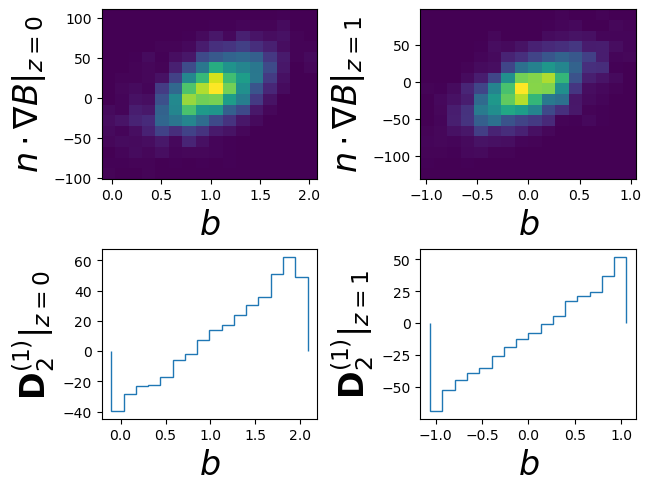

In [159]:
file = h5py.File('snapshots/snapshots_s1.h5', mode='r')

# Interpolate the data (t,x,z) from a Chebyshev grid onto a uniform grid
B_cheb = file['tasks/b' ][pad:,:,:]
Bz_cheb = file['tasks/grad_b'][pad:,1,:,:]# d/dz

# Boundaries (t,x,z)
Y0_Data = B_cheb[:,:,0].flatten() # time,z=0
Y1_Data = B_cheb[:,:,-1].flatten() 
Y0zData = Bz_cheb[:,:,0].flatten() 
Y1zData = Bz_cheb[:,:,-1].flatten() 

nz_minus = -1 # at z=0
nz_plus  =  1 # at z=1

def Expectation(Y,dY,N_bins):
    
    f_YΦ,y_edges,φ = np.histogram2d(Y,dY,range = ((min(Y),max(Y)),(min(dY),max(dY))),bins=N_bins,density=True) # n (-3)
    φ   = .5*(φ[1:]+φ[:-1]); 
    dφ  = φ[1] - φ[0];
    E   = np.sum(φ*f_YΦ,axis=1)*dφ # E{Φ|Y=y}*f(y) = int_φ f_ΦY(φ,y)*φ dφ where φ = n.∇Y_t

    return E,y_edges

def plot_forcing(Y0_Data, Y0zData, Y1_Data, Y1zData, bins=24):
  """
  Plot an estimation of the forcing term
  """

  fig, axs = plt.subplots(nrows=2, ncols=2, layout='constrained')

  axs[0,0].hist2d(x=Y0_Data, y=nz_minus*Y0zData,bins=bins)
  axs[0,0].set_xlabel(r'$b$',fontsize=24)
  axs[0,0].set_ylabel(r'$n \cdot \nabla B |_{z=0}$',fontsize=24)

  fB_minus,_ = np.histogram(Y0_Data.flatten(), bins=bins, density=True)
  E_ndB_minus, b_edges = Expectation(Y0_Data, nz_minus*Y0zData, N_bins=bins)
  axs[1,0].stairs(E_ndB_minus/fB_minus, b_edges)
  axs[1,0].set_xlabel(r'$b$',fontsize=24)
  axs[1,0].set_ylabel(r'$\mathbf{D}^{(1)}_2|_{z=0}$',fontsize=24)

  axs[0,1].hist2d(x=Y1_Data, y=nz_plus*Y1zData,bins=bins)
  axs[0,1].set_xlabel(r'$b$',fontsize=24)
  axs[0,1].set_ylabel(r'$n \cdot \nabla B |_{z=1}$',fontsize=24)

  fB_plus,_ = np.histogram(Y1_Data.flatten(), bins=bins, density=True)
  E_ndB_plus, b_edges = Expectation(Y1_Data, nz_plus*Y1zData, N_bins=bins)
  axs[1,1].stairs(E_ndB_plus/fB_plus, b_edges)
  axs[1,1].set_xlabel(r'$b$',fontsize=24)
  axs[1,1].set_ylabel(r'$\mathbf{D}^{(1)}_2|_{z=1}$',fontsize=24)

  plt.show()

  return None

plot_forcing(Y0_Data, Y0zData, Y1_Data, Y1zData, bins=16)

As evidenced by the previous plots the statistics on the boundary are limited. To improve these statistics we choose to adopt a Monte-Carlo approach by running an ensemble of cases.

INCOMPLETE: As our system is stochastic we must employ a Monte-Carlo approach in order to estimate the terms in this equation. That is we must time integrate the diffusion problem with different realisations of the Ornstein-Ulhenbeck process, and then average over the ensemble of sample paths generated by each run. This is performed below by integrating 250 realisations from $t=0 \to 50$.  

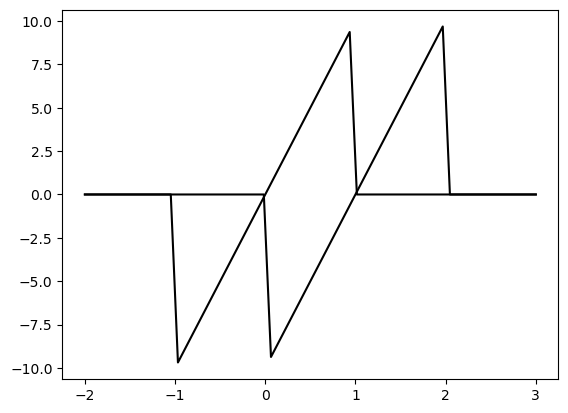

In [165]:
# Partial domain
b = np.linspace(-2, 3, 64)

D_z1 = np.where(b > 1, 0, 10*(b-0))
D_z1 = np.where(b < -1, 0, D_z1)

D_z0 = np.where(b < 0, 0, 10*(b-1))
D_z0 = np.where(b > 2, 0, D_z0)

plt.plot(b,D_z1,'k-')
plt.plot(b,D_z0,'k-')
plt.show()

# Smooth the forcing ?


root = logging.root
for h in root.handlers:
    h.setLevel("WARNING"); 
    
# Generate independent increments
Paths = 50
N = 10**3

# Solve(N=4*400,T=4*50,Nx=192,Nz=48,a=5,σ=1)
# times, z_data,Y_data,Yz_data = Data()

# stp = (len(times)*(Nx*3 // 2), Paths)
# Y0_Data = np.zeros(stp)
# Y1_Data = np.zeros(stp)
# Y0zData = np.zeros(stp)
# Y1zData = np.zeros(stp)

# W  = ss.norm.rvs(loc=0, scale=1, size=(N,2,Paths))

# for n in range(Paths):
    
#     Solve(N,T,Nz,W=W[:,:,n])
    
#     file = h5py.File('snapshots/snapshots_s1.h5', mode='r')

#     # Grab data
#     B_cheb = file['tasks/b' ][:,:,:]
#     Bz_cheb = file['tasks/grad_b'][:,1,:,:]# d/dz

#     # Boundaries (t,x,z)
#     Y0_Data[:,n] = B_cheb[:,:,0].flatten() # time,z=0
#     Y1_Data[:,n] = B_cheb[:,:,-1].flatten() 
#     Y0zData[:,n] = Bz_cheb[:,:,0].flatten() 
#     Y1zData[:,n] = Bz_cheb[:,:,-1].flatten() 
    
#     if n%(Paths//5) == 0:
#         print('Path = %d'%n,'\n')